### Background and business question

##### _Abstract overview of the notebook_

<div>
    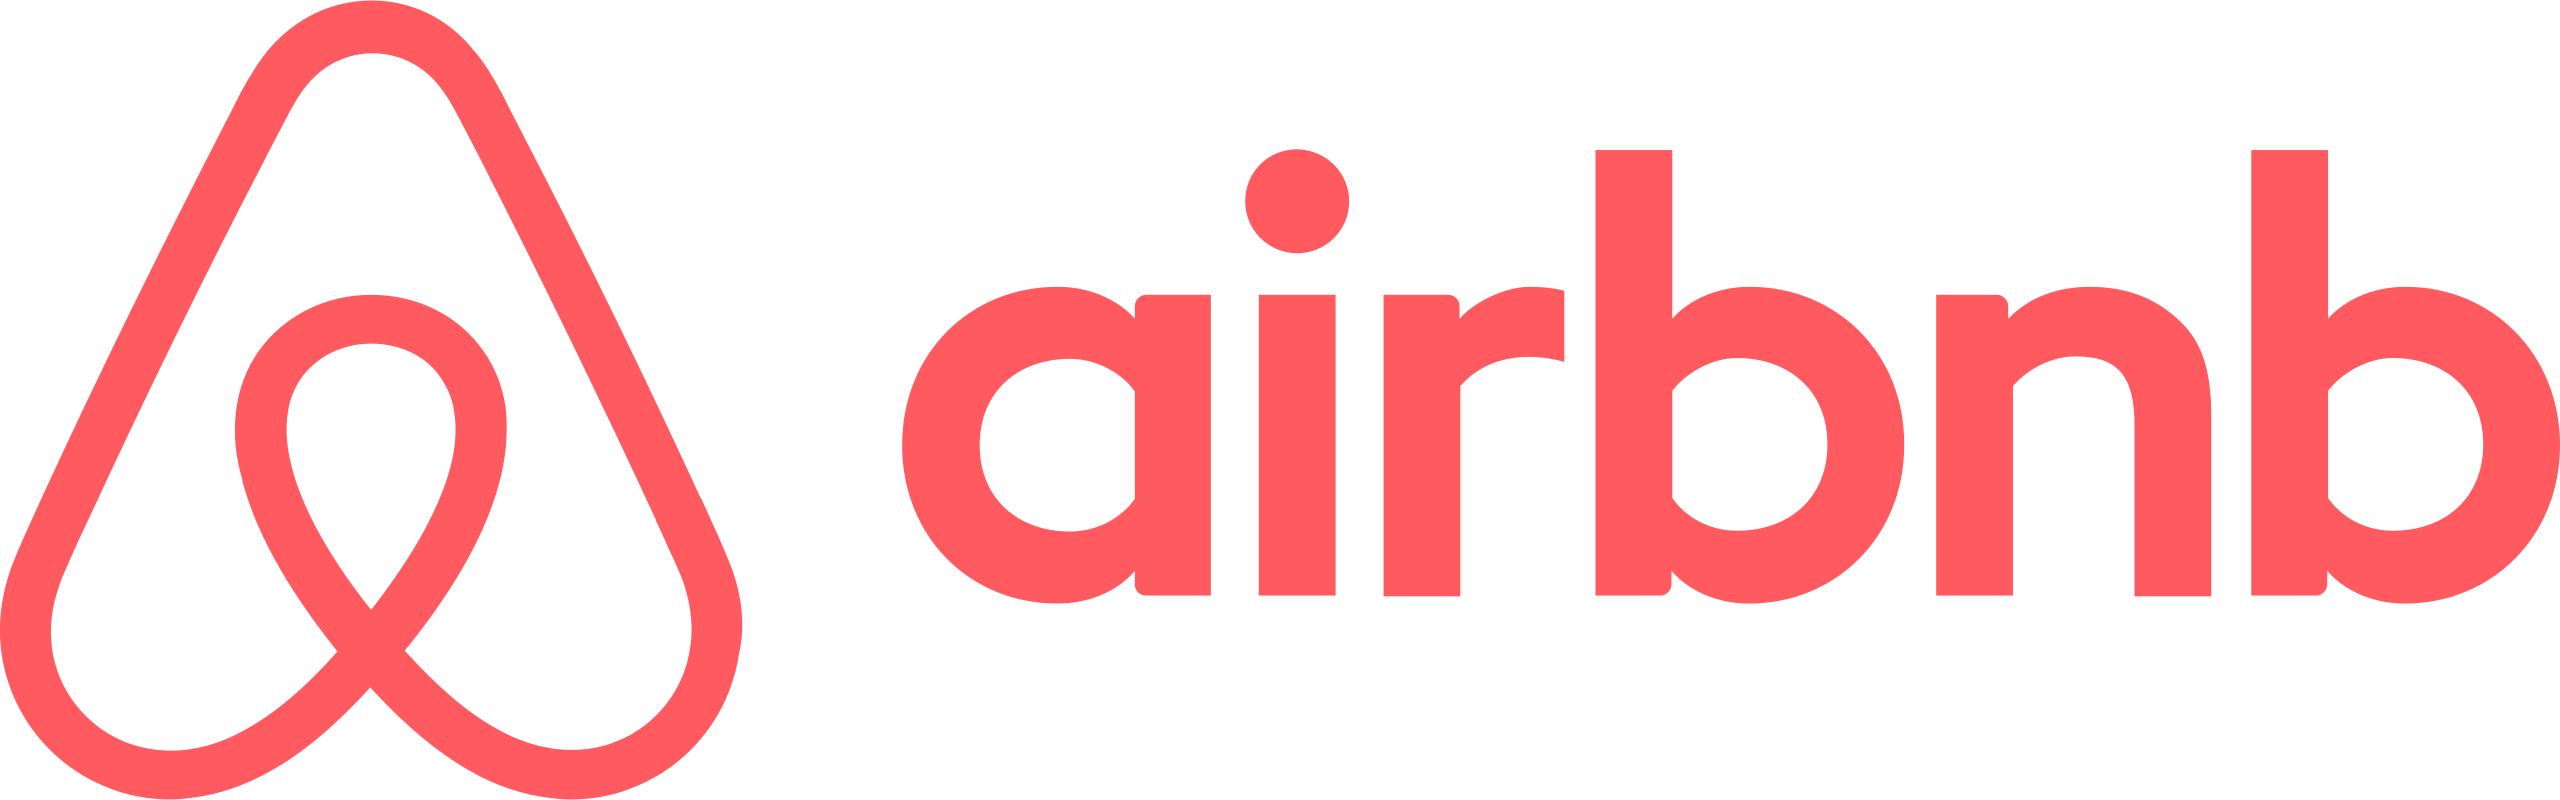
</div>

* The brainchild of Brian Chesky, Nathan Blecharczyk and Joe Gebbia, Airbnb, Inc. was founded upon the idea of space sharing. What was once two designers with space to share hosting three travellers, has transformed into a global online market place for lodging, homestay rentals and tourism activities. Accessible via website and mobile app, Airbnb facilitates millions of hosts and travellers who list their unique spaces and book extraordinary accommodations all over the world.
* As the world emerges from the Covid-19 pandemic, international travel has re-surfaced and tourists are returning with a vengeance. As such, hotel reservations are surging as people look to reconnect, explore new destinations, or revisit reliable favourites.
* Our client, a real estate investor, is interested in purchasing several properties in NYC with the aim of recouping his investment through Airbnb rental commissions. They hope to capitalise on increasing tourism in NYC following the pandemic. 
* The investor has a budget of $XXm and would like to achieve achieve an ROI of XX percent over XX years. Therefore, this project will look to predict the Airbnb prices for various NYC properties to understand how profitable potential property listings would be.  


### Data and statistical question

##### _Abstract overview of the notebook_

* The data consists of ~49,000 observations, with ~48,000 unique listings from ~11,500 hosts across 5 neighbourhood groups in NYC. It contains 16 columns, with a mix of categorical and numeric variables. The dataset is publicly available is from Airbnb, Inc.
* The dataset consists of features extracted from the listing (e.g., number of reviews, availability per year, etc.) and the listing price (per night) which is the target feature. 
* Based on the available data we can use machine learning to predict the listing price of Airbnb's listings (a regression problem) and preict what pricing band the listing will fall under i.e. Low / High prices (classification problem). We chose to compare models for both tasks to see which one is better at addressing the investors concerns of investing in a profitable property / listing for the purpose of renting.
* For the classification problem, a column for the target/response variable "high / low price" will be constructed, based on a threshold of...
* To improve the model's predictive power, additional features have been engineered based on what we expected to be predictive of future Airbnb prices. These were...
* Our statistical question lies pretty close to the investor's business question of is property investment for the purposes of Airbnb rentals worth it i.e. Compared to the initial investment of $XXm, how much rental commissions are possible?


### Loading Data

##### _Presenting the code and methods for acquiring the data. Loading the data into appropriate format for analysis. Explaining the process and results_

In [1]:
#importing necessery libraries for future analysis of the dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns

In [2]:
#using pandas library and 'read_csv' function to read the Airbnb csv file as file already formated for us from Kaggle
airbnb=pd.read_csv("../input/AB_NYC_2019.csv")
#examing head of Airbnb csv file 
airbnb.head(3)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365


In [3]:
#checking amount of rows in given dataset to understand the size we are working with
airbnb.shape

(48895, 16)

In [4]:
#checking type
airbnb.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

16 columns 

### Data Cleaning

##### _Presenting the code and methods for acquiring the data. Loading the data into appropriate format for analysis. Explaining the process and results_

In [5]:
#check null values
airbnb.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [6]:
# drop 'id' & 'host_name' as these features are irrelevant for our prediction, we still have host_id as a reference if needed
# drop 'last_review' due to large amounts of missing values and this feature is less valuable for our predictions
airbnb.drop(['id','host_name','last_review'], axis=1, inplace=True)
airbnb.head(3)

,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Clean & quiet apt home by the park,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Skylit Midtown Castle,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,THE VILLAGE OF HARLEM....NEW YORK !,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365


In [7]:
# there are lots of missing values ~10,052 in reviews_per_month, but the feature may still have some valuable insights
# replacing all NaN values in 'reviews_per_month' with 0
airbnb.fillna({'reviews_per_month':0}, inplace=True)
airbnb.isnull().sum()

name                              16
host_id                            0
neighbourhood_group                0
neighbourhood                      0
latitude                           0
longitude                          0
room_type                          0
price                              0
minimum_nights                     0
number_of_reviews                  0
reviews_per_month                  0
calculated_host_listings_count     0
availability_365                   0
dtype: int64

### Exploring and Visualizing Data

#####  Explaining results

To avoid violation of the golden rule, we need to split the data (20% test and 80% train). The target column, price, will remain in for the purposes of EDA. I set the random seed to 123 for reproducability

In [8]:
# Assign the splits to train_df and test_df
from sklearn.model_selection import train_test_split

# Split the dataset into 80% train and 20% test 
train_df, test_df = train_test_split(airbnb, test_size = 0.2, train_size = 0.8, random_state = 123)

In [9]:
# describe numerical data
train_df.describe()

,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,3.911600e+04,39116.000000,39116.000000,39116.000000,39116.000000,39116.000000,39116.000000,39116.000000,39116.000000
mean,6.745599e+07,40.728990,-73.952224,152.431000,7.028965,23.312762,1.092198,7.107041,112.711167
std,7.860329e+07,0.054456,0.046121,237.950146,20.826066,44.763405,1.611421,32.952899,131.479113
min,2.438000e+03,40.506410,-74.244420,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,7.764177e+06,40.690038,-73.983120,69.000000,1.000000,1.000000,0.040000,1.000000,0.000000
50%,3.073777e+07,40.722970,-73.955660,106.000000,3.000000,5.000000,0.370000,1.000000,45.000000
75%,1.074344e+08,40.763180,-73.936450,175.000000,5.000000,23.000000,1.580000,2.000000,226.000000
max,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [10]:
# describe categorical data
train_df.describe(include=['O'])

,name,neighbourhood_group,neighbourhood,room_type
count,39104,39116,39116,39116
unique,38439,5,220,3
top,New york Multi-unit building,Manhattan,Williamsburg,Entire home/apt
freq,14,17342,3138,20322


In [11]:
#examining the unique values of neighbourhood group 
train_df.neighbourhood_group.value_counts()

Manhattan        17342
Brooklyn         16114
Queens            4502
Bronx              868
Staten Island      290
Name: neighbourhood_group, dtype: int64

In [12]:
#examining the unique values of neighbourhood, show top 5
# 220 unique negihbourhoods in total
train_df.neighbourhood.value_counts()[:5]

Williamsburg          3138
Bedford-Stuyvesant    2985
Harlem                2140
Bushwick              1970
Upper West Side       1611
Name: neighbourhood, dtype: int64

In [13]:
# unique values of room_type 
train_df.room_type.value_counts()

Entire home/apt    20322
Private room       17862
Shared room          932
Name: room_type, dtype: int64

Text(0.5, 1.0, 'Correlation of the Airbnb Features')

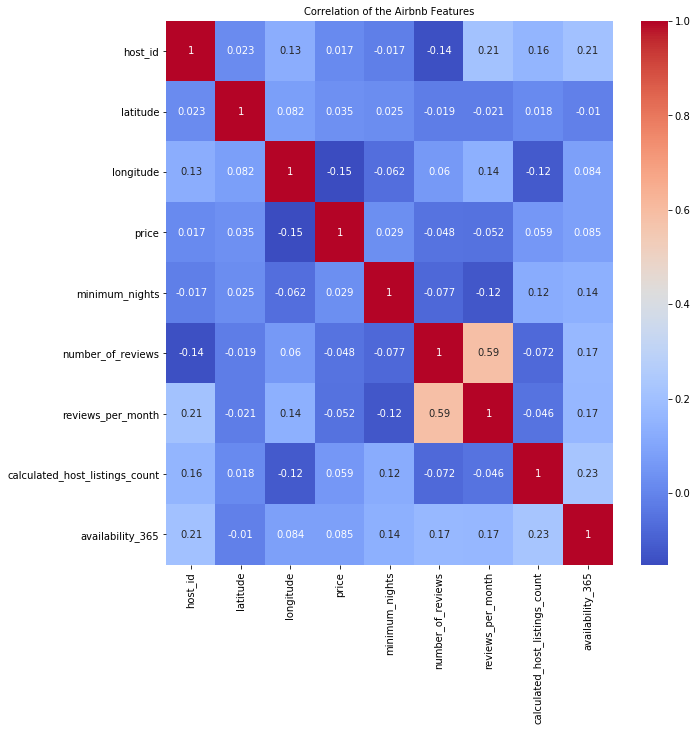

In [14]:
# plot a correlation matrix to check for any feature associations
corr = train_df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True,cmap= "coolwarm")
plt.title("Correlation of the Airbnb Features",size=10)

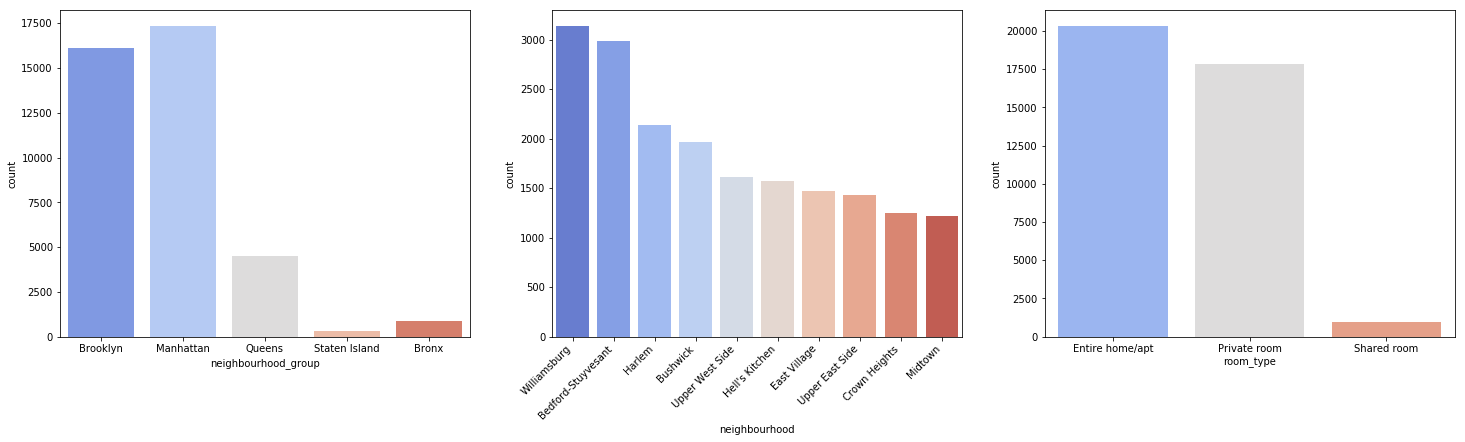

In [15]:
# plot the distribution of Airbnbs by neighbourhood group, specific neighbourhood & room_type
f,(ax1, ax2, ax3) = plt.subplots(1,3, figsize=(25,6))

# plot the distribution of Airbnbs by neighbourhood group, neighbourhood & room_type
ax1 = sns.countplot(train_df.neighbourhood_group, ax=ax1, palette = "coolwarm")
ax2 = sns.countplot(train_df.neighbourhood, ax=ax2, palette = "coolwarm", order = train_df.neighbourhood.value_counts().iloc[:10].index)
ax3 = sns.countplot(train_df.room_type, ax=ax3, palette = "coolwarm")

# sort out ax2 labels 
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")

# show the plots
plt.show()


We can see from the above plots, that the majority of listings are in Manhattan and Brooklyn (~85% of the total listing). 
Of the total listings, the majority are entire home / apartment rentals and private rooms. 

Text(0.5, 1.0, 'Density and distribution of prices across Neighbourhood Groups')

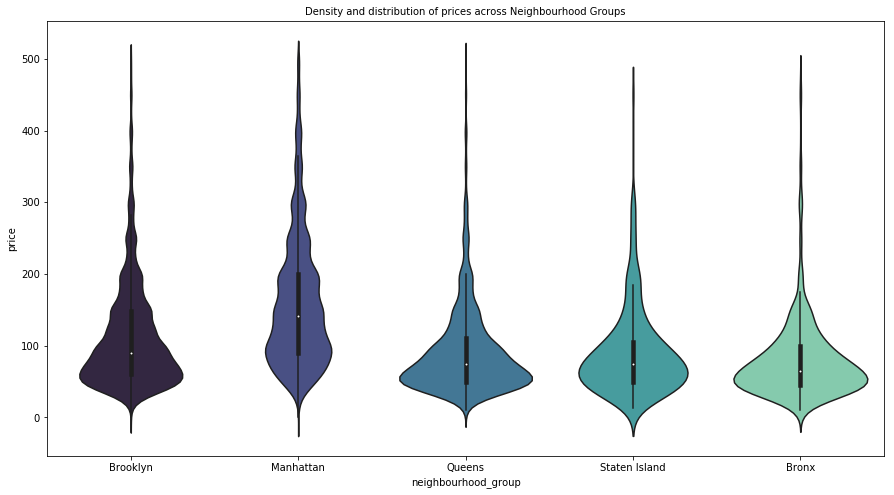

In [16]:
# plot the distribution and density of prices for across neighbourhood_groups 
# remove extreme / influencial observations 
cheap_bnb =train_df[train_df.price < 500]
# use a violinplot to plot dist and density
plt.figure(figsize=(15,8))
cbnb =sns.violinplot(data=cheap_bnb, x='neighbourhood_group', y='price', palette = 'mako')
cbnb.set_title('Density and distribution of prices across Neighbourhood Groups',size=10)

This plot shows that:
* Brooklyn, Queens, Staten Island and the Bronx have a high concentration of listing around the 60 - 80 dollar mark.
* Manhattan has a more distributed price range, which the highest density of listings priced at 100 dollars, but still a fair portion of listings are priced above this. This makes sense as Manhattan is a more expensive / sought after location.
* This needs to be factored into the client analysis as currently, based off price distribution alone, Manhattan could be a great location for an investment given potential returns. 

Text(0.5, 1.0, 'Room availability across Neighbourhood Groups')

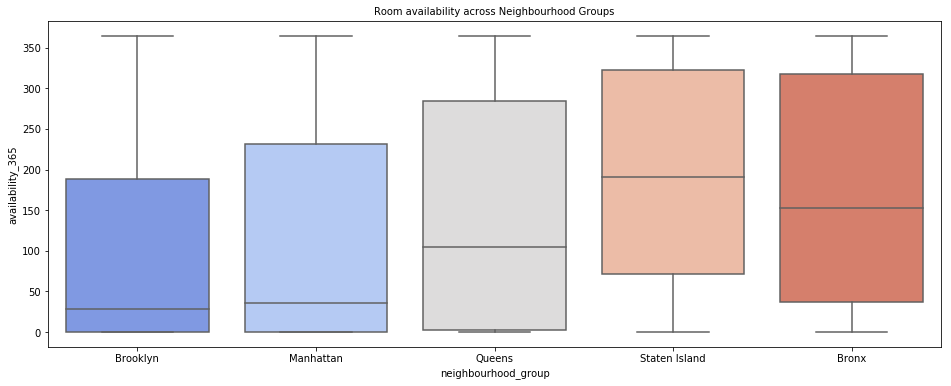

In [17]:
# plot listing availability across the different neighbourhood groups using a boxplot
plt.figure(figsize=(16,6))
avail = sns.boxplot(data=train_df, x='neighbourhood_group',y='availability_365',palette='coolwarm')
plt.title("Room availability across Neighbourhood Groups",size=10)

* Manhattan & Brooklyn are mainly available for a fewer days in the year vs Queens, Staten and the Bronx. 
* Bronx & Manhattan have a similar median, however, Manhattans listing availability is more widely distributed. 
* All neighbourhoods have some listings open year round. 

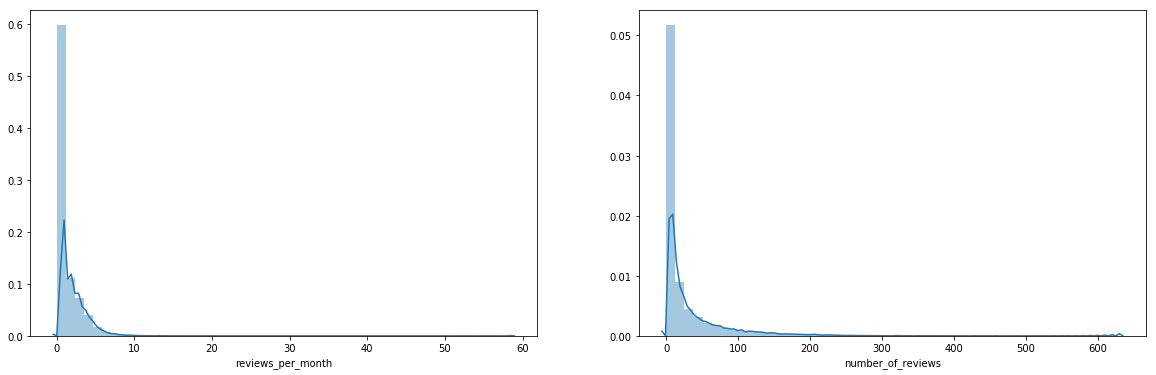

In [18]:
# plot the reviews_per_month & number_of_reviews to see the distribution
f,(ax4, ax5) = plt.subplots(1,2, figsize=(20,6))

# plot the distribution of Airbnbs by neighbourhood group, neighbourhood & room_type
ax4 = sns.distplot(train_df.reviews_per_month, ax=ax4)
ax5 = sns.distplot(train_df.number_of_reviews, ax=ax5)

# show the plots
plt.show()

It appears that for the majority of listings across all neighbourhood groups, 1 - 2 reviews are left per month. Also ~ 0 - 20 reviews are left for Airbnb's on average as per the left plot. 

Text(0.5, 1.0, 'Mininmum night stays in AirBnbs')

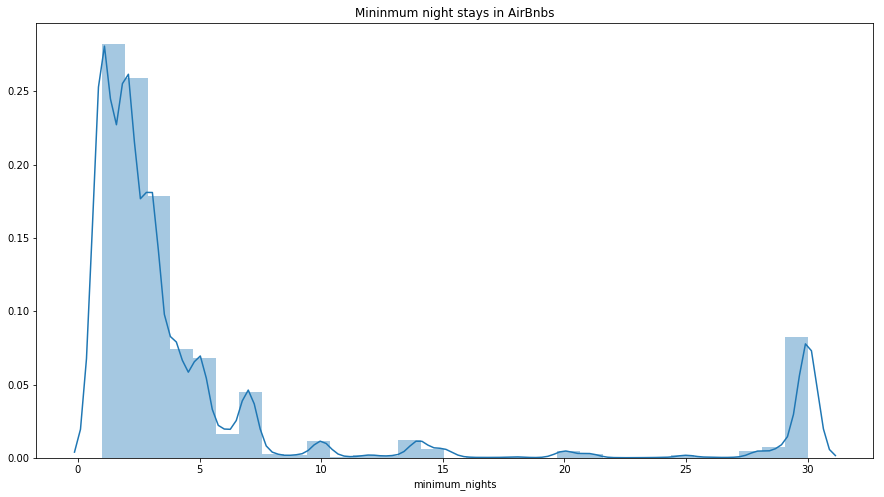

In [19]:
# to sense check the above, plot the minimum nights stay 
plt.figure(figsize=(15,8))
sns.distplot(train_df[(train_df['minimum_nights'] <= 30)]['minimum_nights'], bins=31)
plt.ioff()
plt.title("Mininmum night stays in AirBnbs")

The largest proportion of required minimum stays is 1 night.
The minimum night stays are skewed to the left, with 1 - 8 nights representing the majority of all listings. 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


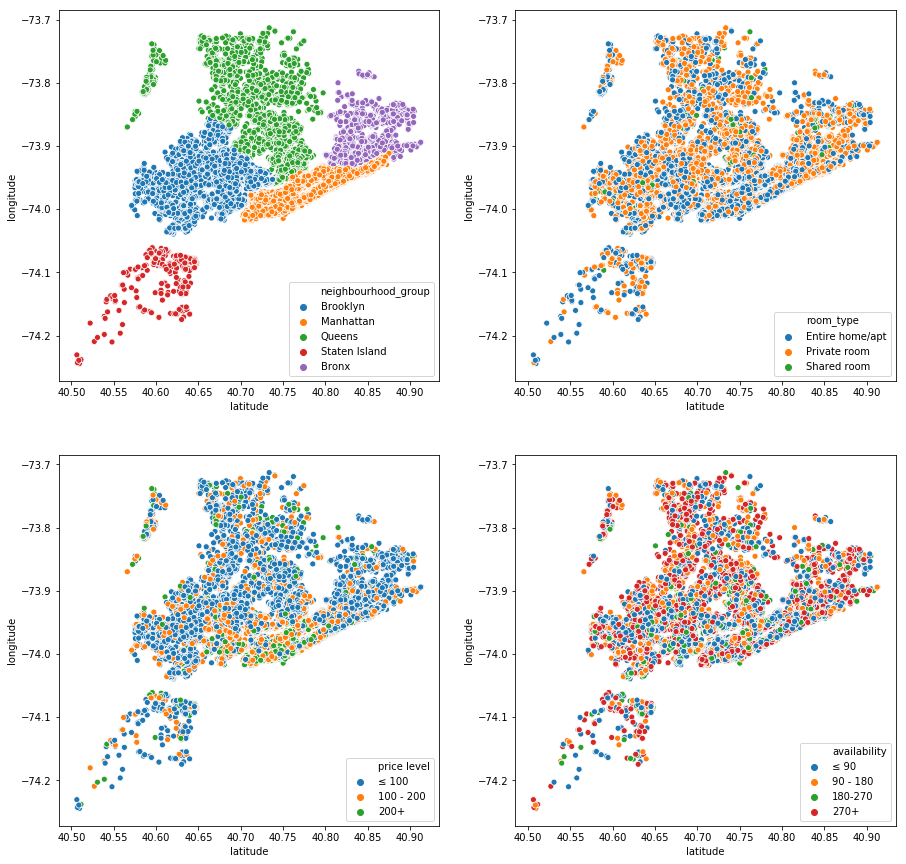

In [20]:
# plot the distribution of neighbourhoods, room_type,  price level and availability
plt.figure(figsize = (15, 15))

# add two new columns to the train_df, this is purely for the purpose of plotting / visualisation 
# bin the prices and availability into different levels
train_df['price level'] = pd.cut(train_df["price"], [0, 100, 200, 12000], labels=["≤ 100", "100 - 200", "200+"])
train_df['availability'] = pd.cut(train_df["availability_365"], [0, 90, 180, 270, 365], labels=["≤ 90", "90 - 180", "180-270", "270+"])

# create 2x2 subplots showing the distribution of neighbourhoods, room_type,  price level and availability
plt.subplot(221)
sns.scatterplot(x="latitude", y="longitude",hue="neighbourhood_group", data=train_df)
plt.subplot(222)
sns.scatterplot(x="latitude", y="longitude",hue="room_type", data=train_df)
plt.subplot(223)
sns.scatterplot(x="latitude", y="longitude",hue="price level", data=train_df)
plt.subplot(224)
sns.scatterplot(x="latitude", y="longitude",hue="availability", data=train_df)

* The majority of listings are for enitre home / apt and private rooms as shown by plot 2.
* As expected, Manhattan prices are skewed towards the higher end (reateively sparse number of blue dots in the area) vs. the lower price points of other neighbourhood groups as shown in plot 3.

In [21]:
# drop the previously created columns required for visualisation
train_df = train_df.drop(['price level'] , axis = 1)
train_df = train_df.drop(['availability'] , axis = 1)

In [22]:
# check the dataframe is in order
train_df.head()

,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
9601,Clean and Sunny Brooklyn apt!!,11129295,Brooklyn,Bushwick,40.70178,-73.92829,Entire home/apt,98,4,1,0.02,1,0
45574,Spacious Harlem Home in Manhattan!,9486614,Manhattan,Harlem,40.81157,-73.94654,Entire home/apt,799,3,0,0.00,1,51
33996,Modern and Tranquil Apartment on Riverside Drive!,202636642,Manhattan,Upper West Side,40.79485,-73.97550,Entire home/apt,146,3,28,3.31,1,158
11829,Midtown Hells Kitch. Next to Timesq,36430529,Manhattan,Hell's Kitchen,40.75997,-73.99265,Entire home/apt,250,2,0,0.00,1,0
41134,Paris Private Room W/Private Bathroom,237421509,Brooklyn,Bedford-Stuyvesant,40.67818,-73.92284,Private room,55,1,3,0.58,2,0


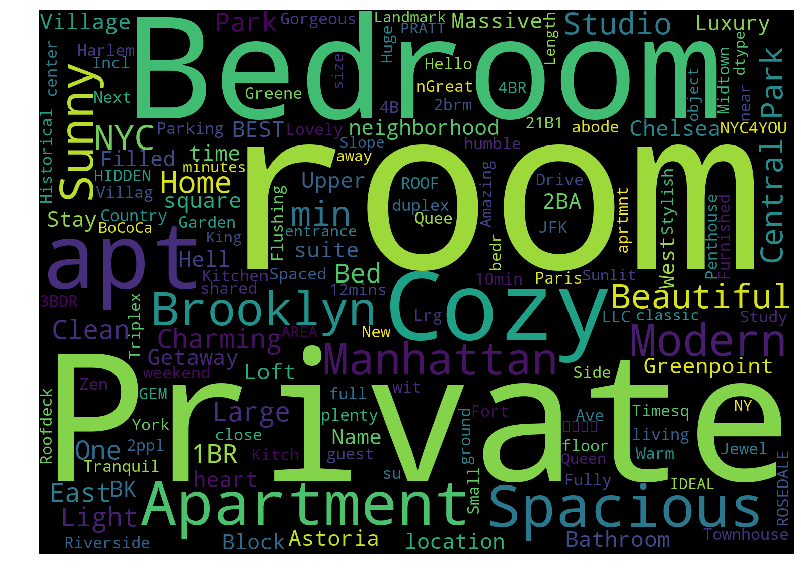

In [23]:
# create a wordcloud plot showing the most popular words in the name (description of the listing)
from wordcloud import WordCloud
plt.subplots(figsize=(15,10))
wordcloud = WordCloud(
                          background_color='black',
                          width=1500,
                          height=1080
                         ).generate(str(train_df.name))
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('neighbourhood.png')
plt.show()

The most frequently used words in the name feature are Private, Room, and Bedroom. This is inline with the other plots, indicating private rooms are more prominent than shared rooms. 

### Modeling

##### We will perform a regression anaysis, regressing the various features onto the target feature, price. 

In [24]:
df = airbnb.drop(['name','host_id'], axis=1)
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


In [25]:
df.isnull().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [26]:
# check for null values
train_df.isnull().sum()

name                              12
host_id                            0
neighbourhood_group                0
neighbourhood                      0
latitude                           0
longitude                          0
room_type                          0
price                              0
minimum_nights                     0
number_of_reviews                  0
reviews_per_month                  0
calculated_host_listings_count     0
availability_365                   0
dtype: int64

In [27]:
categorical_features = df.select_dtypes(include=['object'])
print('Categorical features: {}'.format(categorical_features.shape))

categorical_features_one_hot = pd.get_dummies(categorical_features)
categorical_features_one_hot.head()

numerical_features =  df.select_dtypes(exclude=['object'])
numerical_features = numerical_features.drop(['price'], axis=1)

X = pd.concat([numerical_features, categorical_features_one_hot], axis=1)

Categorical features: (48895, 3)


In [28]:
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#X = df.drop(columns=["price"])
y = df["price"]

from sklearn.model_selection import train_test_split
# Split the dataset into 80% train and 20% test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train.head()

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,...,neighbourhood_Williamsburg,neighbourhood_Willowbrook,neighbourhood_Windsor Terrace,neighbourhood_Woodhaven,neighbourhood_Woodlawn,neighbourhood_Woodrow,neighbourhood_Woodside,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
9601,40.70178,-73.92829,4,1,0.02,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
45574,40.81157,-73.94654,3,0,0.00,1,51,0,0,1,...,0,0,0,0,0,0,0,1,0,0
33996,40.79485,-73.97550,3,28,3.31,1,158,0,0,1,...,0,0,0,0,0,0,0,1,0,0
11829,40.75997,-73.99265,2,0,0.00,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
41134,40.67818,-73.92284,1,3,0.58,2,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [29]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor


#Prepairng a Decision Tree Regression
from sklearn.tree import DecisionTreeRegressor

tree=DecisionTreeRegressor()
tree.fit(X_train,y_train)

y_predict=tree.predict(X_test)
from sklearn.metrics import r2_score
r2_score(y_test,y_predict)

-0.9773444051567717

In [30]:
result = pd.DataFrame({'Actual': y_test, 
                   'Predicted': y_predict})
result.head(30)

,Actual,Predicted
29122,35,110.0
2964,85,120.0
14184,55,45.0
1174,99,100.0
42853,75,55.0
12409,289,300.0
22622,125,265.0
23384,225,96.0
15294,65,100.0
22143,116,125.0


In [31]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.metrics import r2_score

print('MAE: %f'% mean_absolute_error(y_test, y_predict))
print('RMSE: %f'% np.sqrt(mean_squared_error(y_test, y_predict)))   
print('R2 %f' % r2_score(y_test, y_predict))

MAE: 86.685039
RMSE: 349.817684
R2 -0.977344


In [32]:
#Linear Regression


from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X_train,y_train)
reg.score(X_train, y_train)  

0.1193550444613698

In [33]:
# perform a robust scaler transform of the dataset
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
imputer = SimpleImputer(strategy="median")
imputer.fit(X_train);
X_train_imp = imputer.transform(X_train)
X_test_imp = imputer.transform(X_test)
X_train_imp
X_train_imp_df = pd.DataFrame(X_train_imp, columns = X_train.columns, index = X_train.index)
X_train_imp_df.head()
scaler = StandardScaler()
X_train_scaled_std = scaler.fit_transform(X_train_imp)
X_test_scaled_std = scaler.transform(X_test_imp)
pd.DataFrame(X_train_scaled_std, columns=X_train.columns, index=X_train.index)
#USe a Linear Regression Model to fit the training data
reg.fit(X_train_scaled_std,y_train)
reg.score(X_train_scaled_std, y_train)  

0.11904973185240364